In [1]:
import json
import re

### Feed Forward Neural Network Parameters

In [2]:
SEED = 400
# 1st Layer
LAYER1_SIZE = 16
LAYER1_ACTIVATION = 'relu'
LAYER1_INPUT_DIMENSION = 10000

LAYER1_PARAMS = [str(LAYER1_SIZE), LAYER1_ACTIVATION, LAYER1_INPUT_DIMENSION]

# 2nd LAYER
LAYER2_SIZE = 16
LAYER2_ACTIVATION = 'relu'

LAYER2_PARAMS = [str(LAYER2_SIZE), LAYER2_ACTIVATION]

# 3rd LAYER
LAYER3_SIZE = 4
LAYER3_ACTIVATION = 'sigmoid'

LAYER3_PARAMS = [str(LAYER3_SIZE), LAYER3_ACTIVATION]

# Geralizers
DROPOUT_RATE = 0.5
L1 = 0.001
L2 = 0.001

# TRAINING
EPOCHS = 5
BATCH_SIZE = 64

TRAIN_PARAMS = [EPOCHS, BATCH_SIZE]

# COMPILATION
OPTIMIZER = 'rmsprop'
LOSS = 'binary_crossentropy'
METRICS = 'accuracy'

COMPILATION_PARAMS = [OPTIMIZER, LOSS, METRICS]

In [3]:
# This file contains 8600ish users Data
# In the form: {'MBTI Type', 'Social Media Posts'}
dataFile = open('formatted_data.json', 'r')

In [4]:
data = []

In [5]:
# loading the json data into a list
for line in dataFile:
    data.append(json.loads(line))

In [6]:
types = []
posts = []

In [7]:
# Separating data into 2 separate lists for preprocessing
# For the most part we process the 'post' data
# we skip the first element as that is only the label
for i in range(1, len(data)):
    types.append(data[i]['Type'])
    #posts.append(data[i]['Post'])

In [8]:
import pickle

tokenized_posts = []
with open ('tokenized_formatted_data.txt', 'rb') as fp:
    tokenized_posts = pickle.load(fp)

In [9]:
all_words_list = []

for user in tokenized_posts:
    for word in user:
        all_words_list.append(word)

In [10]:
from collections import Counter

In [11]:
freq_list = Counter(all_words_list)
dictionary = freq_list.most_common(10000)

In [12]:
dictionary = list(zip(*dictionary))[0]

In [13]:
nums = range(0, 10000)
word_int = dict(zip(dictionary, nums))

In [14]:
x_vals = []

for user in tokenized_posts:
    x_vals.append([word_int[x] for x in user if x in word_int.keys()])

In [15]:
type_dictionary = {
    '0000':'INTJ',
    '0001':'INTP',
    '0010':'INFJ',
    '0011':'INFP',
    '0100':'ISTJ',
    '0101':'ISTP',
    '0110':'ISFJ',
    '0111':'ISFP',
    '1000':'ENTJ',
    '1001':'ENTP',
    '1010':'ENFJ',
    '1011':'ENFP',
    '1100':'ESTJ',
    '1101':'ESTP',
    '1110':'ESFJ',
    '1111':'ESFP',
}

type_labels=['INTJ','INTP','INFJ','INFP','ISTJ','ISTP','ISFJ','ISFP', \
        'ENTJ','ENTP','ENFJ','ENFP','ESTJ','ESTP','ESFJ','ESFP',]

one_hot_types = []
for type in types:
    bin_type = []
    if (type[0] == 'I'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (type[1] == 'N'):
        bin_type.append(0)
    else:
        bin_type.append(1)
        
    if (type[2] == 'T'):
        bin_type.append(0)
    else:
        bin_type.append(1)
    
    if (type[3] == 'J'):
        bin_type.append(0)
    else:
        bin_type.append(1)
    one_hot_types.append(bin_type)
    

In [16]:
import numpy as np
import random

x = np.array(x_vals)
random.seed(SEED)
random.shuffle(x)
test_data = x[:1500]
train_data = x[1500:]

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [17]:
from keras.utils.np_utils import to_categorical

y = np.asarray(one_hot_types).astype('float32')
random.seed(SEED)
random.shuffle(y)
y_test = y[:1500]
y_train = y[1500:]

Using TensorFlow backend.


In [18]:
x_val = x_train[:1500]
x_partial_train = x_train[1500:]

y_val = y_train[:1500]
y_partial_train = y_train[1500:]

In [19]:
# FEED FORWARD MODEL

from keras import models
from keras import layers
from keras import regularizers
import tensorflow as tf
#kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(LAYER1_SIZE, activation=LAYER1_ACTIVATION, input_shape = (LAYER1_INPUT_DIMENSION,)))
    model.add(layers.Dense(LAYER2_SIZE, activation=LAYER2_ACTIVATION))
    model.add(layers.Dense(LAYER3_SIZE, activation=LAYER3_ACTIVATION))
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = [METRICS])
    return model

In [26]:
counter = 0
for label in types:
    if label == 'INFP':
        counter +=1
counter

1832

In [20]:
model = build_model()
with tf.device('/gpu:0'):
    history = model.fit(x_partial_train, y_partial_train, epochs = 40, batch_size = 1024, validation_data=(x_val, y_val))

Train on 5675 samples, validate on 1500 samples
Epoch 1/40
5675/5675 [==============================] - 1s 144us/step - loss: 0.5995 - acc: 0.6925 - val_loss: 0.5728 - val_acc: 0.7057
Epoch 2/40
5675/5675 [==============================] - 1s 96us/step - loss: 0.5587 - acc: 0.7165 - val_loss: 0.5713 - val_acc: 0.7023
Epoch 3/40
5675/5675 [==============================] - 1s 109us/step - loss: 0.5410 - acc: 0.7307 - val_loss: 0.5715 - val_acc: 0.7003
Epoch 4/40
5675/5675 [==============================] - 1s 97us/step - loss: 0.5267 - acc: 0.7477 - val_loss: 0.5716 - val_acc: 0.7037
Epoch 5/40
5675/5675 [==============================] - 1s 129us/step - loss: 0.5107 - acc: 0.7565 - val_loss: 0.5737 - val_acc: 0.7052
Epoch 6/40
5675/5675 [==============================] - 1s 96us/step - loss: 0.4978 - acc: 0.7703 - val_loss: 0.5753 - val_acc: 0.7015
Epoch 7/40
5675/5675 [==============================] - 1s 98us/step - loss: 0.4877 - acc: 0.7723 - val_loss: 0.5832 - val_acc: 0.7045
Epoc

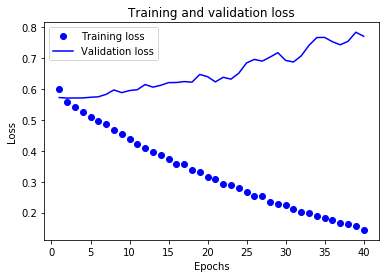

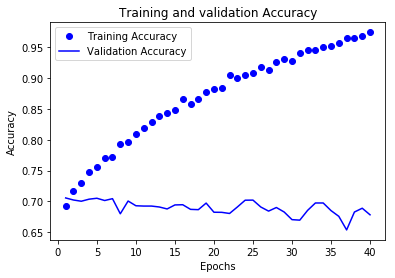

In [22]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['acc']
val_acc   = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()